# Using RRTMG with Python

This pre-class assignment has just three parts. There's nothing to change within the code, just run and read through each cell!

You'll be:
 - Loading GCM output to make the water vapor profile
 - Initializing the RRTMG model using climlab
 - Looking at some RRTMG output 

https://brian-rose.github.io/ClimateLaboratoryBook/courseware/radeq.html#the-observed-annual-global-mean-temperature-profile

# Import Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp 
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

# Make Water Vapor Profile Using GCM output

This is typical GCM output. The coordinates include elevation, time, latitude, longitude, and staggered lat + lon.

In [4]:
cesm_data_path = "/data/keeling/a/mailes2/a/CESM_DATA/aqua_75perturb/outputdata/atm/hist/"
cesm_input = xr.open_dataset(cesm_data_path + "aqua_75perturb.cam.h0.0005-12.nc")
cesm_input

<xarray.Dataset>
Dimensions:        (lev: 30, ilev: 31, time: 1, lat: 96, lon: 144, slat: 95,
                    slon: 144, nbnd: 2)
Coordinates:
  * lev            (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time           (time) object 0006-01-01 00:00:00
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon            (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat           (slat) float64 -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon           (slon) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
Dimensions without coordinates: nbnd
Data variables: (12/163)
    hyam           (lev) float64 ...
    hybm           (lev) float64 ...
    hyai           (ilev) float64 ...
    hybi           (ilev) float64 ...
    P0             float64 ...
    date           (time) int32 ...
    ...             ...
    pom_a1_SRF     (time, lat, lon) float32 ...
    so4_a1_SRF     (time, lat, lon) float32 ...
    so4_a2_SRF     (time, lat, lon) float32 ...
    so4_a3_SRF     (time, lat, lon) float32 ...
    soa_a1_SRF     (time, lat, lon) float32 ...
    soa_a2_SRF     (time, lat, lon) float32 ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             aqua_75perturb
    title:            UNSET
    logname:          mailes2
    host:             keeling-j31
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /data/keeling/a/mailes2/a/CESM_DATA/CESM_INPUT_DATA/atm...
    topography_file:  /data/keeling/a/mailes2/a/CESM_DATA/CESM_INPUT_DATA/atm...

This is specific humidity.

In [10]:
cesm_Q = xr.open_dataarray('Data/cesm_Q_preclass.nc')
cesm_Q

<xarray.DataArray 'Q' (time: 1, lev: 26, lat: 46, lon: 72)>
array([[[[1.390297e-06, ..., 1.390297e-06],
         ...,
         [1.374150e-06, ..., 1.374150e-06]],

        ...,

        [[4.030460e-04, ..., 4.030460e-04],
         ...,
         [2.071450e-04, ..., 2.071451e-04]]]], dtype=float32)
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0002-01-01 00:00:00
  * lat      (lat) float64 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float64 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

Here's the Gaussian weights, which we'll use to weight the humidity by latitudinal area.

In [8]:
cesm_gw = xr.open_dataarray('Data/cesm_gw.nc')
cesm_gw

<xarray.DataArray 'gw' (lat: 46)>
array([0.000609, 0.004869, 0.009714, 0.014512, 0.019239, 0.023873, 0.02839 ,
       0.032769, 0.036988, 0.041027, 0.044866, 0.048486, 0.051871, 0.055002,
       0.057866, 0.060448, 0.062735, 0.064716, 0.066383, 0.067726, 0.068739,
       0.069417, 0.069756, 0.069756, 0.069417, 0.068739, 0.067726, 0.066383,
       0.064716, 0.062735, 0.060448, 0.057866, 0.055002, 0.051871, 0.048486,
       0.044866, 0.041027, 0.036988, 0.032769, 0.02839 , 0.023873, 0.019239,
       0.014512, 0.009714, 0.004869, 0.000609])
Coordinates:
  * lat      (lat) float64 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
Attributes:
    long_name:  gauss weights

Here's the global averaged specific humidity. Its only dimension is in the vertical.

In [11]:
# Take the global, annual average of the specific humidity
weight_factor = cesm_gw / cesm_gw.mean(dim='lat')
Qglobal = (cesm_Q * weight_factor).mean(dim=('lat','lon','time'))

Qglobal

<xarray.DataArray (lev: 26)>
array([1.39990332e-06, 1.38893905e-06, 1.38156388e-06, 1.37433686e-06,
       1.37460203e-06, 1.39379091e-06, 1.40387096e-06, 1.35234617e-06,
       1.48410010e-06, 1.96904209e-06, 3.43752013e-06, 7.51882336e-06,
       1.75160742e-05, 4.14602103e-05, 9.75360764e-05, 2.04862670e-04,
       3.84822596e-04, 6.84581346e-04, 1.27919482e-03, 1.88429141e-03,
       3.03203178e-03, 4.77728061e-03, 6.48281598e-03, 8.30766457e-03,
       9.29907219e-03, 9.57205902e-03])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6

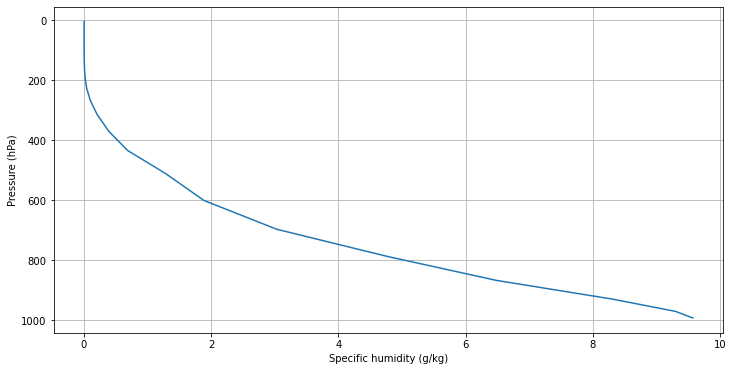

In [12]:
plt.rcParams["figure.figsize"] = (12,6)

#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air

plt.plot(Qglobal*1000., Qglobal.lev)
plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.xlabel('Specific humidity (g/kg)')
plt.grid()
plt.show()

# Create Single Model 

Let's look at how to create a model in climlab to run through RRTMG! We'll need to initiate a column_state, which is a variable dictionary of atmospheric temperatures ('Tatm') and surface mixed layer temperature ('Ts').

In [7]:
help(climlab.column_state)

Help on function column_state in module climlab.domain.initial:

column_state(num_lev=30, num_lat=1, lev=None, lat=None, water_depth=1.0)
    Sets up a state variable dictionary consisting of temperatures
    for atmospheric column (``Tatm``) and surface mixed layer (``Ts``).
    
    Surface temperature is always 288 K. Atmospheric temperature is initialized
    between 278 K at lowest altitude and 200 at top of atmosphere according to
    the number of levels given.
    
    **Function-call arguments** 
    
    
    :param int num_lev:         number of pressure levels
                                (evenly spaced from surface to top of atmosphere)
                                [default: 30]
    :param int num_lat:         number of latitude points on the axis
                                [default: 1]
    :param lev:                 specification for height axis (optional)
    :type lev:                  :class:`~climlab.domain.axis.Axis`
                                or pre

In [14]:
mystate = climlab.column_state(lev=Qglobal.lev, # These are the elevation levels. We'll be using CESM's elev. levels.
                               water_depth=2.5 
                              )
mystate

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

We're ready to set up the RRTMG model now!

In [15]:
radmodel_LW = climlab.radiation.RRTMG_LW(name='Shortwave Radiation', # Model name
                              state=mystate,                         # Initial temperature conditions
                              specific_humidity=Qglobal.values,      # Water vapor - coming from the CESM output
                              albedo = 0.25                          # Surface shortwave albedo
                             )
radmodel_LW

In [16]:
radmodel_SW = climlab.radiation.RRTMG_SW(name='Longwave Radiation', # Model name
                              state=mystate,                        # Initial temperature conditions
                              specific_humidity=Qglobal.values,     # Water vapor - coming from the CESM output
                              albedo = 0.25                         # Surface shortwave albedo
                             )
radmodel_SW

## Check Model State 

In [17]:
radmodel_LW.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

The model has many different parameters initialized. lev gives us the pressure levels.

In [18]:
radmodel_LW.lev

array([  3.544638 ,   7.3888135,  13.967214 ,  23.944625 ,  37.23029  ,
        53.114605 ,  70.05915  ,  85.439115 , 100.514695 , 118.250335 ,
       139.115395 , 163.66207  , 192.539935 , 226.513265 , 266.481155 ,
       313.501265 , 368.81798  , 433.895225 , 510.455255 , 600.5242   ,
       696.79629  , 787.70206  , 867.16076  , 929.648875 , 970.55483  ,
       992.5561   ])

absorber_vmr gives us the volume mixing ratio of all active gases in the column.

Here, we assume that all gasses except ozone are well mixed. 

In [19]:
radmodel_LW.absorber_vmr 

{'CO2': 0.000348,
 'CH4': 1.65e-06,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CCL4': 0.0,
 'O3': array([7.52507018e-06, 8.51545793e-06, 7.87041289e-06, 5.59601020e-06,
        3.46128454e-06, 2.02820936e-06, 1.13263102e-06, 7.30182697e-07,
        5.27326553e-07, 3.83940962e-07, 2.82227214e-07, 2.12188506e-07,
        1.62569291e-07, 1.17991442e-07, 8.23582543e-08, 6.25738219e-08,
        5.34457156e-08, 4.72688637e-08, 4.23614749e-08, 3.91392482e-08,
        3.56025264e-08, 3.12026770e-08, 2.73165152e-08, 2.47190016e-08,
        2.30518624e-08, 2.22005071e-08])}

# Running RRTMG and Finding Radiative Flux
https://climlab.readthedocs.io/en/latest/api/climlab.radiation.Radiation.html

We run the model using compute_diagnostics()

In [20]:
radmodel_LW.compute_diagnostics()

radmodel_SW.compute_diagnostics()

In [21]:
radmodel_LW.heating_rate

{'Ts': Field([-94.91615665]),
 'Tatm': Field([ -0.94509702,  -0.49705194,  -0.7380587 ,  -0.85491906,
         -0.90083158,  -0.90967491,  -0.85772191,  -0.8094699 ,
         -0.95867417,  -1.32661268,  -2.05747026,  -3.67819934,
         -6.14784132,  -9.31521329, -12.69417759, -14.11836721,
        -14.95327903, -15.67145665, -17.44263424, -15.98609994,
        -14.25261372, -11.39956263,  -8.07753665,  -5.0111357 ,
         -0.82301341,   3.27949025])}

Net longwave flux

In [22]:
radmodel_LW.LW_flux_net

Field([252.06337925, 251.11828224, 250.62123029, 249.88317159,
       249.02825253, 248.12742096, 247.21774605, 246.36002414,
       245.55055424, 244.59188007, 243.26526739, 241.20779713,
       237.52959779, 231.38175647, 222.06654318, 209.37236559,
       195.25399838, 180.30071935, 164.6292627 , 147.18662846,
       131.20052851, 116.94791479, 105.54835216,  97.47081551,
        92.45967982,  91.6366664 ,  94.91615665])

Let's plot the net longwave flux and net shortwave flux.

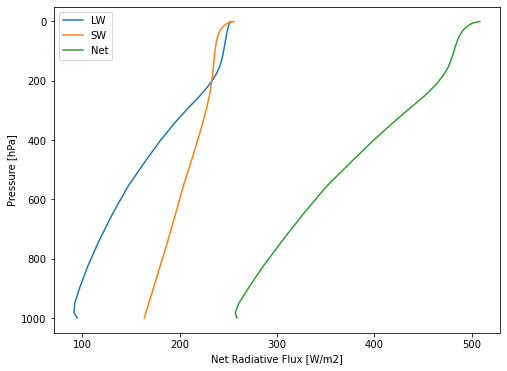

In [24]:
plt.rcParams["figure.figsize"] = (8,6)

plt.plot(radmodel_LW.LW_flux_net, radmodel_LW.lev_bounds, label='LW')
plt.plot(radmodel_SW.SW_flux_net, radmodel_SW.lev_bounds, label='SW')
plt.plot(radmodel_LW.LW_flux_net+radmodel_SW.SW_flux_net, radmodel_LW.lev_bounds, label='Net')
plt.gca().invert_yaxis()
plt.xlabel('Net Radiative Flux [W/m2]')
plt.ylabel('Pressure [hPa]')
plt.legend()

Let's plot the heating rates, too.

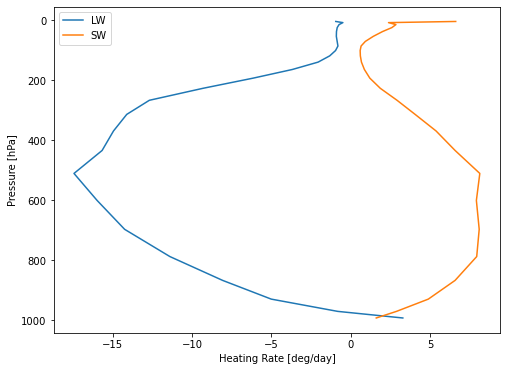

In [26]:
plt.plot(radmodel_LW.heating_rate['Tatm'], radmodel_LW.lev, label='LW')
plt.plot(radmodel_SW.heating_rate['Tatm'], radmodel_SW.lev, label='SW')
#plt.plot(radmodel_LW.heating_rate['Tatm']+radmodel_SW.heating_rate['Tatm'], radmodel.lev, label='Net')
plt.gca().invert_yaxis()
plt.ylabel('Pressure [hPa]')
plt.xlabel('Heating Rate [deg/day]')
plt.legend()